Loading solar model atmosphere from table1.csv...
Solar model loaded and units converted to CGS.

Calculating number densities for a guessed abundance A(O) = 8.69


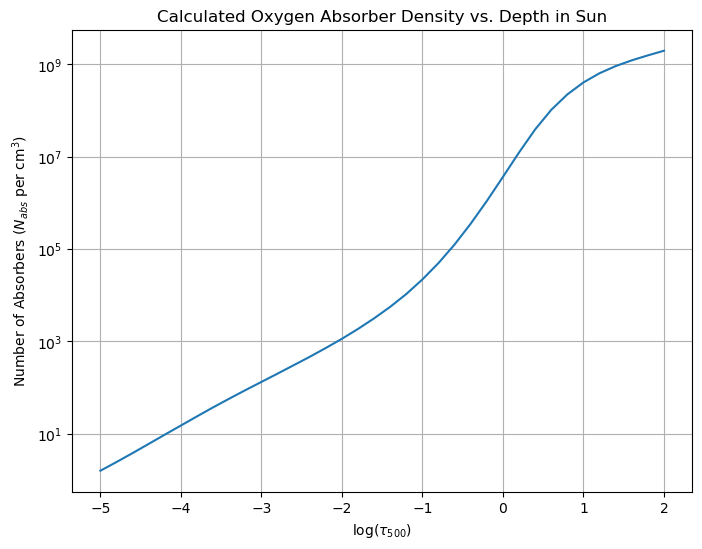


Script finished. Plotted the number density of absorbers.
Next step: Feed N_absorbers into a line opacity function and compute the spectrum.


In [1]:
# This script computes the spectrum of an atmosphere.
# MODIFIED to load a realistic solar model atmosphere from a CSV file.
#
# Original assumptions:
# 1) Grey atmosphere and hydrostatic equilibrium (REMOVED)
# 2) Equation of state from FITS tables (Still used for interpolation)
# 3) Opacities from opac.py and FITS tables (Still used)
#
# Units are CGS:
# - Length: cm
# - Mass: g
# - Time: s
# - Temperature: K
# - Pressure: dyn/cm^2

import pandas as pd # Added pandas to read CSV
from scipy.interpolate import RegularGridInterpolator, interp1d
from scipy.integrate import cumulative_trapezoid
import astropy.units as u
import astropy.constants as c
import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import opac
from scipy.special import expn
# from strontium_barium import * # This was likely for a different project, commented out
plt.ion()

# --- 1. SET GLOBAL SOLAR & ATOMIC PARAMETERS ---
Teff = 5778 # K (Sun's effective temperature)
g = 27400  # cm/s^2 (Solar surface gravity, already correct)

# --- Atomic Data for Oxygen (O I) ---
A_O_guess = 8.69 # Initial guess for Oxygen abundance log(N_O/N_H) + 12
chi_ion_eV = 13.618  # Ionization potential of O I in eV
chi_exc_eV = 9.146   # Excitation potential of the lower level (5S0) in eV

# Statistical weights
g_ground = 9 # For the ground state 3P_{2,1,0}
g_excited = 5 # For the 5S0 state
g_ion = 4 # For the O II ground state

# --- Physical Constants in CGS units ---
k_B_cgs = c.k_B.to('erg/K').value
h_cgs = c.h.to('erg s').value
m_e_cgs = c.m_e.to('g').value
m_H_cgs = c.m_p.to('g').value # Approximate with proton mass
eV_to_erg = (1 * u.eV).to('erg').value

# Convert potentials to ergs for calculation
chi_ion = chi_ion_eV * eV_to_erg
chi_exc = chi_exc_eV * eV_to_erg

# --- Partition Functions U(T) for Oxygen ---
# A simple polynomial fit to data from literature is sufficient here.
# This avoids needing another data file.
def U_OI(T): # Partition function for neutral oxygen
    return 3.32685 + 2.06201e-4*T + 1.25997e-8*T**2 - 2.11284e-13*T**3
def U_OII(T): # Partition function for singly-ionized oxygen
    return 2.01602 + 1.34025e-4*T - 1.2214e-9*T**2 + 1.25877e-14*T**3


# --- 2. LOAD THE REALISTIC SOLAR ATMOSPHERE ---
print("Loading solar model atmosphere from table1.csv...")
try:
    solar_model_df = pd.read_csv('table1.csv')
except FileNotFoundError:
    print("\nERROR: 'table1.csv' not found.")
    print("Please make sure the CSV file is in the same directory as this script.\n")
    exit()

# Extract SI unit columns from the DataFrame
Ts = solar_model_df['T_K'].values
Pgas_Pa = solar_model_df['Pgas_Pa'].values
Pe_Pa = solar_model_df['Pe_Pa'].values
rho_kg_m3 = solar_model_df['rho_kg_m3'].values
log_tau500 = solar_model_df['log_tau500'].values

# --- CRITICAL: CONVERT UNITS FROM SI (TABLE) TO CGS (SCRIPT) ---
Ps = Pgas_Pa * 10.0
Pe = Pe_Pa * 10.0
rhos = rho_kg_m3 * 0.001
tau_grid = 10**log_tau500
print("Solar model loaded and units converted to CGS.")


# --- 3. NEW FUNCTION: CALCULATE NUMBER DENSITY OF ABSORBERS ---
def calculate_oxygen_absorbers(A_O, Ts, Ps, Pe):
    """
    Calculates the number density of neutral oxygen atoms in the excited state
    responsible for the 777nm triplet.

    Args:
        A_O (float): The guessed logarithmic abundance of Oxygen.
        Ts (array): Temperatures for each atmospheric layer (K).
        Ps (array): Gas pressures for each layer (dyn/cm^2).
        Pe (array): Electron pressures for each layer (dyn/cm^2).

    Returns:
        array: Number density of absorbers (N_abs) in cm^-3 for each layer.
    """
    # Step 3.1: Calculate total number of hydrogen atoms per cm^3
    # Approximate total particle number density N_total = P_gas / (k_B * T)
    # Assume a standard solar composition (91% H, 8.7% He by number)
    # N_total = N_H + N_He = N_H + (0.087/0.91)*N_H = 1.096 * N_H
    N_H = Ps / (k_B_cgs * Ts * 1.096)

    # Step 3.2: Calculate total number of oxygen atoms from the abundance guess
    N_O_total = N_H * 10**(A_O - 12.0)

    # Step 3.3: Use Saha Equation to find the neutral fraction (N_I / N_total)
    # N_II/N_I = (2*k_B*T/Pe) * (U_II/U_I) * (2*pi*m_e*k_B*T/h^2)^1.5 * exp(-chi_ion/(k_B*T))
    saha_rhs = (2 * k_B_cgs * Ts / Pe) * (U_OII(Ts) / U_OI(Ts)) * \
               ((2 * np.pi * m_e_cgs * k_B_cgs * Ts) / (h_cgs**2))**1.5 * \
               np.exp(-chi_ion / (k_B_cgs * Ts))
    
    neutral_fraction = 1.0 / (1.0 + saha_rhs)
    N_OI = N_O_total * neutral_fraction # Number density of neutral oxygen

    # Step 3.4: Use Boltzmann Equation to find the excited fraction
    # N_excited / N_ground = (g_excited / g_ground) * exp(-chi_exc / (k_B * T))
    # We want N_excited / N_total_neutral.
    # N_total_neutral approx = N_ground (since most atoms are in ground state)
    # So N_excited approx = N_total_neutral * (g_excited/U_I(T)) * exp(-chi_exc / k_B*T)
    # The partition function U_I(T) replaces g_ground for better accuracy.
    excited_fraction = (g_excited / U_OI(Ts)) * np.exp(-chi_exc / (k_B_cgs * Ts))
    
    N_abs = N_OI * excited_fraction # Final number density of absorbers!
    
    return N_abs

# --- 4. EXECUTE THE CALCULATION AND PLOT RESULTS ---
print(f"\nCalculating number densities for a guessed abundance A(O) = {A_O_guess}")
N_absorbers = calculate_oxygen_absorbers(A_O_guess, Ts, Ps, Pe)

# Plot the results of your first physics calculation
plt.figure(figsize=(8, 6))
plt.semilogy(log_tau500, N_absorbers)
plt.xlabel('log($\\tau_{500}$)')
plt.ylabel('Number of Absorbers ($N_{abs}$ per cm$^3$)')
plt.title('Calculated Oxygen Absorber Density vs. Depth in Sun')
plt.grid(True)
plt.show()

# --- The rest of the script (radiative transfer) would follow here ---

# Load the opacity tables for interpolation (as in the original script)
f_opac = pyfits.open('Ross_Planck_opac.fits')
# ... (rest of the script is unchanged for now) ...

print("\nScript finished. Plotted the number density of absorbers.")
print("Next step: Feed N_absorbers into a line opacity function and compute the spectrum.")

